In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline

In [2]:
#loads all the provided datasets
orders = pd.read_csv("BigSupplyCo_Orders.csv",index_col=0)
product_cat = pd.read_csv("BigSupplyCo_Categories.csv",index_col=0)
products = pd.read_csv("BigSupplyCo_Products.csv")
departments = pd.read_csv("BigSupplyCo_Departments_Cleaned.csv")

In [3]:
#merges product categories on products
products = pd.merge(left=products,right=product_cat,left_on="Product Category Id",right_on="Category Id",how="left")
products.set_index("Product Card Id",inplace=True)

In [4]:
#merges products on orders
orders = pd.merge(left=orders,right=products,left_on="Order Item Cardprod Id",right_on="Product Card Id",how="left")

In [5]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 180519 entries, 0 to 180518
Data columns (total 31 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   Order Id                       180519 non-null  int64  
 1   Order Item Cardprod Id         180519 non-null  int64  
 2   Order Customer Id              180519 non-null  int64  
 3   Order Department Id            180519 non-null  int64  
 4   Market                         180519 non-null  object 
 5   Order City                     180519 non-null  object 
 6   Order Country                  180519 non-null  object 
 7   Order Region                   180519 non-null  object 
 8   Order State                    180519 non-null  object 
 9   Order Status                   180519 non-null  object 
 10  Order Zipcode                  24840 non-null   float64
 11  order date (DateOrders)        180519 non-null  object 
 12  Order Item Discount           

In [6]:
orders["Order Item Id"].nunique()

180519

In [7]:
orders["Order Item Cardprod Id"].nunique()

118

In [8]:
orders["Order Id"].nunique()

65752

There are more "Order Item Id" than "Order Id". This means that each row corresponds to 1 item and each order consists of multiple items. So in order to find the total info of an order, all the items of each order must be grouped together.

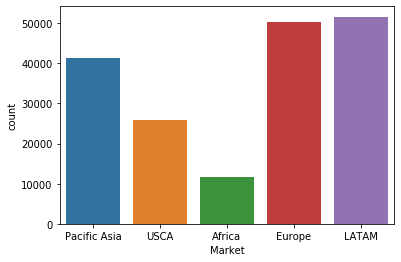

In [9]:
sns.countplot("Market",data=orders)

In [10]:
market_profits = orders.sort_values(by="Order Profit",ascending=False).groupby(by="Market").sum()["Order Profit"]
market_profits.sort_values(ascending=False)

Market
Europe          1.169443e+06
LATAM           1.123322e+06
Pacific Asia    8.577534e+05
USCA            5.643138e+05
Africa          2.520712e+05
Name: Order Profit, dtype: float64

The regions with the most profits follow the same order as with the most orders. There's no anomaly in regards to the correlation between number of orders and profits.

Most orders don't have an order zipcode. Can't use this feature.

In [11]:
product_cat["Category Id"] = product_cat.index
category_profits = orders.groupby(by="Category Name").sum()[["Order Profit"]]
category_profits.columns = ["Total Profits"]
category_profits = pd.merge(left=category_profits,right=product_cat,on="Category Name")
category_profits.sort_values(by="Total Profits",ascending=False,inplace=True)
category_profits.index= range(0,len(category_profits))
category_profits.head(10)

,Category Name,Total Profits,Category Id
0,Fishing,756220.767190,45
1,Cleats,494636.919791,17
2,Camping & Hiking,427455.568106,43
3,Cardio Equipment,383011.098485,9
4,Women's Apparel,350421.029567,24
5,Water Sports,325146.960038,48
6,Indoor/Outdoor Games,318451.430554,46
7,Men's Footwear,311902.820214,18
8,Shop By Sport,129813.960315,29
9,Computers,69656.810171,64


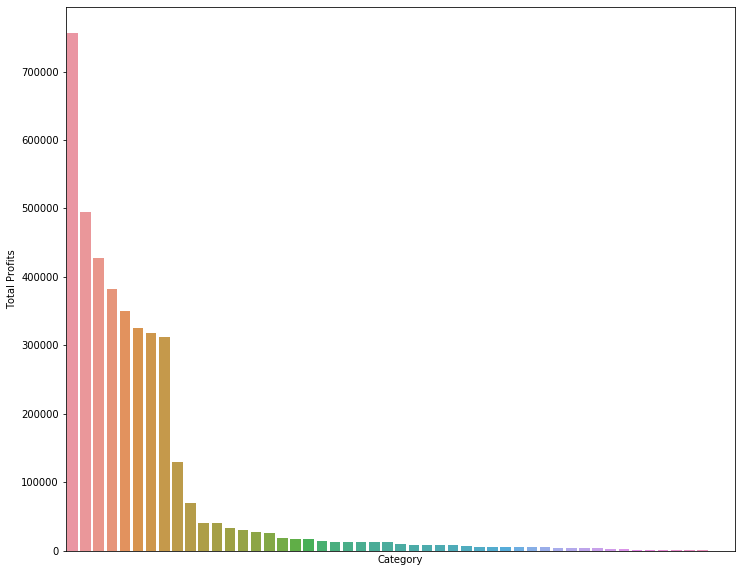

In [12]:
fig = plt.figure(figsize=(12,10))
sns.barplot(category_profits.index,category_profits["Total Profits"])
plt.xticks([])
plt.xlabel("Category");

Most of the profits are contributed by the 10 most profitable categories.

In [13]:
print(category_profits[:10]["Total Profits"].sum()/category_profits["Total Profits"].sum() * 100)

88.99452041240045


About 89% of the profits are due to the 10 most profitable categories so these will be focused.

In [14]:
profitable_cat = category_profits[:10]["Category Name"]

In [15]:
orders_bycnt = orders.groupby(by="Order Country").sum()
orders_bycnt.sort_values(by="Order Profit",ascending=False,inplace=True)
orders_bycnt.head(20)["Order Profit"]

Order Country
Estados Unidos          540413.070422
Francia                 327828.580099
México                  303278.370637
Alemania                194827.080381
Brasil                  186713.640355
Reino Unido             180942.880424
Australia               170041.580432
China                   122190.920525
Italia                  121545.470087
India                    99746.819972
España                   93547.639826
Indonesia                90714.079721
Honduras                 85173.809995
República Dominicana     84401.019917
El Salvador              77051.909965
Turquía                  70910.659854
Nicaragua                66033.600079
Cuba                     60624.030139
Nigeria                  53436.540101
Filipinas                47687.919908
Name: Order Profit, dtype: float64

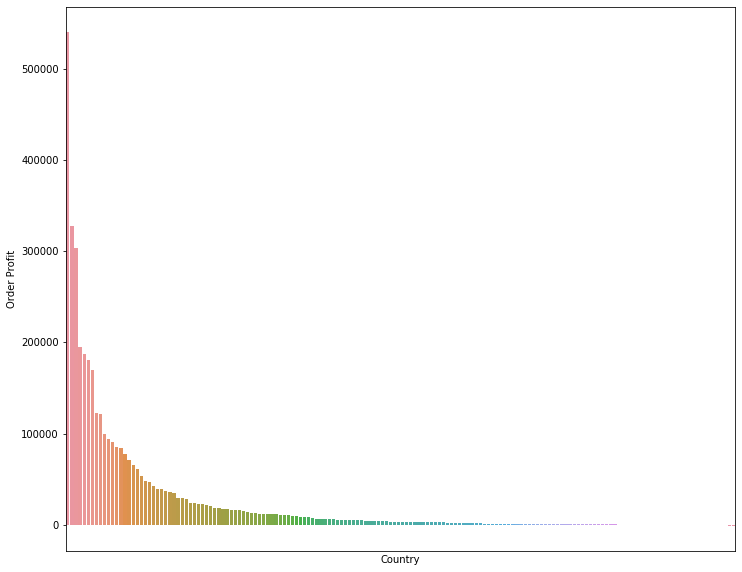

In [16]:
fig = plt.figure(figsize=(12,10))
sns.barplot(orders_bycnt.index,orders_bycnt["Order Profit"])
plt.xticks([])
plt.xlabel("Country");

In [17]:
orders_bycnt[:40]["Order Profit"].sum()/orders_bycnt["Order Profit"].sum() * 100

89.45274932855136

About 90% of the profits are due to the 40 most profitable countries/locations so these will be focused.

In [18]:
profitable_cnt = orders_bycnt.index[:40]

In [19]:
orders_clean = orders[orders["Category Name"].isin(profitable_cat) & orders["Order Country"].isin(profitable_cnt)]

In [20]:
orders_clean["Order Profit"].sum()/orders["Order Profit"].sum() * 100

80.31639630982625

Data has been cleaned to include only the most profitable categories and countries. The remaining orders account for 80% of the total profits.

In [21]:
country_profits = orders_clean[["Category Name","Order Country","Order Profit"]]
country_profits = country_profits.groupby(["Order Country","Category Name"]).sum()

country_profits = country_profits.pivot_table(values="Order Profit",index = "Order Country",columns="Category Name")
country_profits.fillna(0,inplace=True)

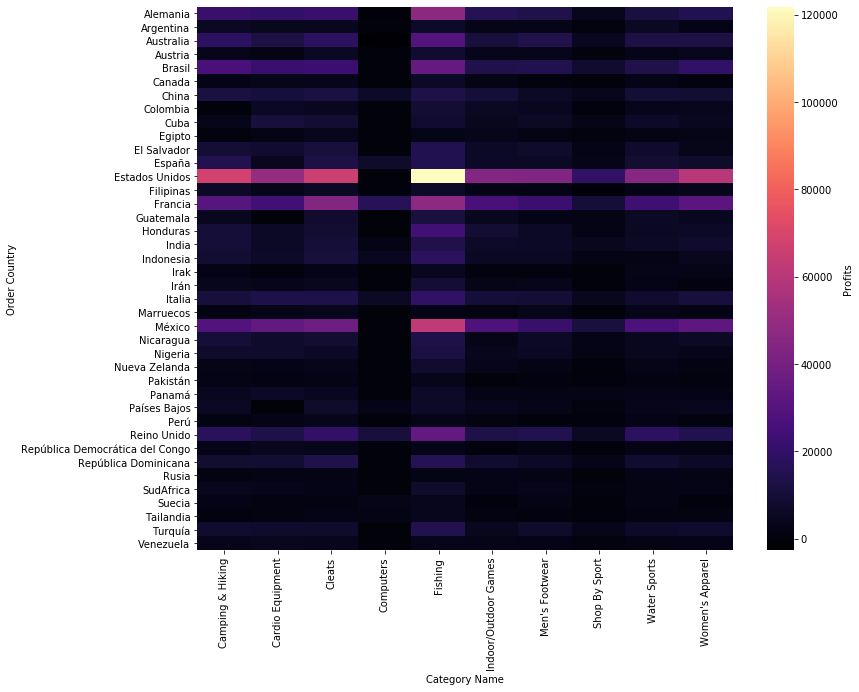

In [22]:
plt.figure(figsize=(12,10))
profits_map = sns.heatmap(country_profits,cmap="magma")
profits_map.collections[0].colorbar.set_label("Profits")

The most profitable combinations of category and country are indicated on the heatmap.

In [23]:
df = pd.read_csv("https://raw.githubusercontent.com/weijuinlee/datathon/main/BigSupplyCo_Data_Files%20/geolocateddataset.csv?token=GHSAT0AAAAAABMK6536E2YPUFJAZVX3NG74YRTMEMA",index_col=0)

In [24]:
df["Delay"] = df["Days for shipping (real)"] - df["Days for shipment (scheduled)"]
orders["Delay"] = orders["Days for shipping (real)"] - orders["Days for shipment (scheduled)"]

Delay=0: There's no delay in the order shipment
<br>Delay>0: The order shipment is delayed
<br>Delay<0: The order was shipped sooner than expected

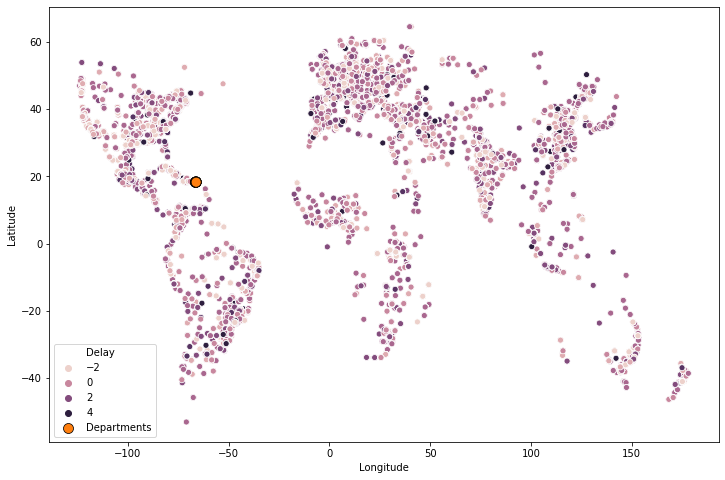

In [29]:
plt.figure(figsize=(12,8))
delays_plot = sns.scatterplot("long","lat",data=df,hue="Delay")
dept_dot = sns.scatterplot("Longitude","Latitude",data=departments,size=1,sizes=[100],label="Departments",edgecolor="black")
h,l = delays_plot.get_legend_handles_labels()
h2,l2 = dept_dot.get_legend_handles_labels()
h2.append(h)
l2.append(l)
plt.legend(h2[:6],l2[:6]);

The delays seem to be evenly distributed around the countries, so geographical location probably doesn't affect them.

In [30]:
df["Delay"].value_counts()

 1    60647
 0    33753
 2    28718
-1    21700
-2    21666
 3     7052
 4     6983
Name: Delay, dtype: int64

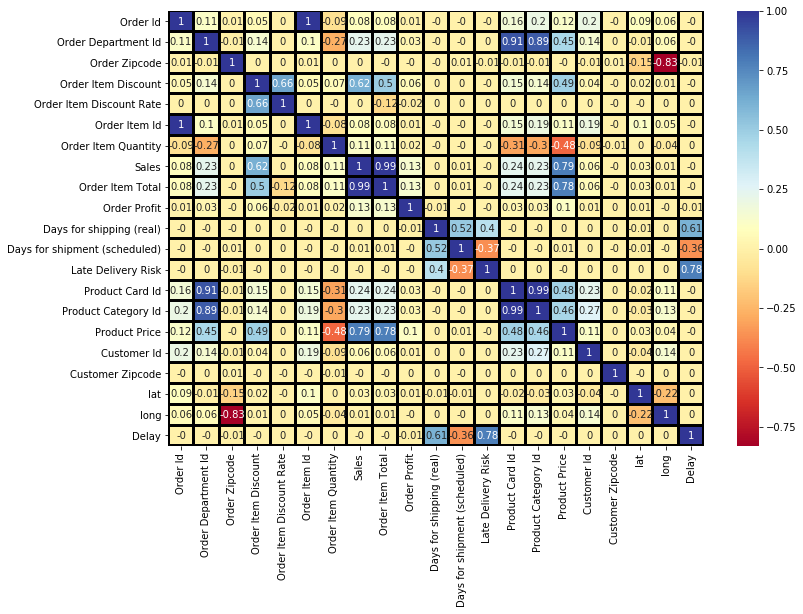

In [31]:
plt.figure(figsize=(12,8))
corr = np.round(df.drop("Product Status",axis=1).corr(),2)
sns.heatmap(corr,cmap="RdYlBu",linecolor="black",linewidth=2,annot=True);


In [32]:
pd.set_option('display.max_columns', None)
ts = orders.sort_values(by="order date (DateOrders)")

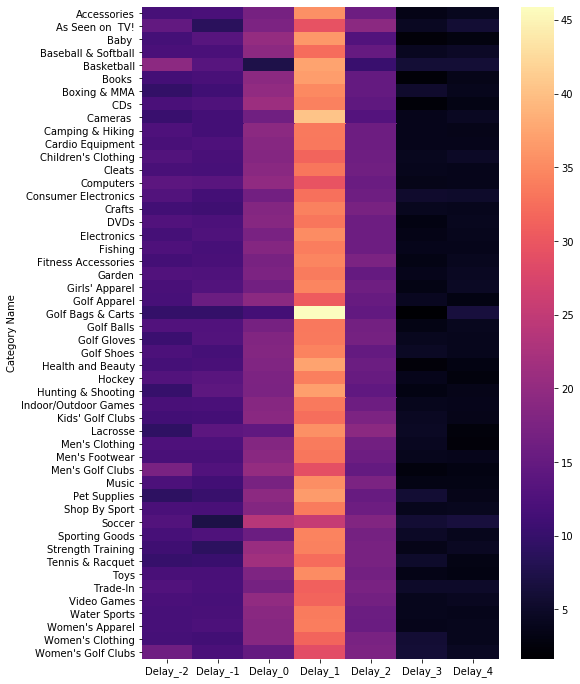

In [33]:
plt.figure(figsize=(8,12))
orders["Counter"] = 1
ord_del = pd.get_dummies(orders,columns=["Delay"])
ord_del = ord_del.groupby(by="Category Name").sum()
ord_del=ord_del[["Delay_-2","Delay_-1","Delay_0","Delay_1","Delay_2","Delay_3","Delay_4"]].div(ord_del["Counter"]/100,
                                                                                               axis=0)
ord_del = ord_del[["Delay_-2","Delay_-1","Delay_0","Delay_1","Delay_2","Delay_3","Delay_4"]]
sns.heatmap(ord_del,cmap ="magma");

The number of orders with each delay value for the various categories is shown, as a percentage of the total number of orders of each category. Most orders for most of the categories have 1 day delay.

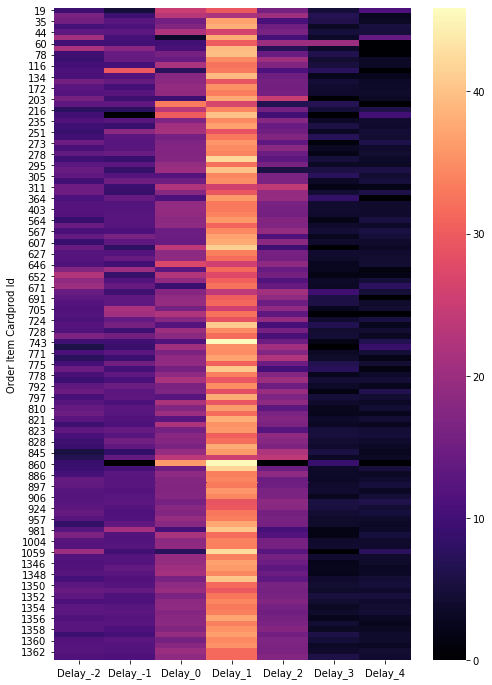

In [34]:
plt.figure(figsize=(8,12))
prod_del = pd.get_dummies(orders,columns=["Delay"])
prod_del = prod_del.groupby(by="Order Item Cardprod Id").sum()
prod_del=prod_del[["Delay_-2","Delay_-1","Delay_0","Delay_1","Delay_2","Delay_3","Delay_4"]].div(prod_del["Counter"]/100,
                                                                                               axis=0)
prod_del = prod_del[["Delay_-2","Delay_-1","Delay_0","Delay_1","Delay_2","Delay_3","Delay_4"]]
sns.heatmap(prod_del,cmap ="magma");

The number of orders with each delay value for the various products is shown, as a percentage of the total number of orders of each product. Most orders for most of the products have 1 day delay.

In [35]:
import datetime

In [36]:
orders["order date (DateOrders)"] = pd.to_datetime(orders["order date (DateOrders)"])

In [37]:
orders["Date"] = orders["order date (DateOrders)"].apply(datetime.datetime.date)

In [38]:
profits_by_date = orders.groupby(by="Date").sum()
profits_by_date.sort_values(by="Date",inplace=True)
profits_by_date.head(10)

,Order Id,Order Item Cardprod Id,Order Customer Id,Order Department Id,Order Zipcode,Order Item Discount,Order Item Discount Rate,Order Item Id,Order Item Quantity,Sales,Order Item Total,Order Profit,Days for shipping (real),Days for shipment (scheduled),Late Delivery Risk,Product Category Id,Product Description,Product Price,Product Status,Delay,Counter
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,5486,116186,957017,921,0.0,3426.400004,19.10,14196,355,32806.090690,29379.700398,4433.480025,630,553,91,5276,0.0,23117.000611,0,77,168
2015-01-02,16163,98329,914275,806,0.0,3016.359999,15.44,37807,354,29818.210575,26801.900242,1292.849976,578,541,64,4481,0.0,19101.200493,0,37,154
2015-01-03,30712,117186,1133243,947,0.0,3489.449987,16.54,73748,392,36348.710648,32859.300341,5366.600017,679,559,105,5323,0.0,24519.850592,0,120,179
2015-01-04,45946,120765,1163325,999,0.0,3869.510000,19.91,114027,410,35738.970669,31869.500330,5630.989989,623,572,100,5514,0.0,23611.930567,0,51,191
2015-01-05,49401,104679,911927,841,0.0,3534.920025,18.22,123600,373,31067.910603,27533.050215,3088.100046,600,482,95,4757,0.0,19401.090491,0,118,160
2015-01-06,63636,115681,996964,919,0.0,3320.590006,17.19,158353,368,33395.710577,30075.160363,723.970058,650,536,88,5255,0.0,22517.970542,0,114,169
2015-01-07,72003,112855,1146308,892,0.0,2989.839999,14.27,177422,350,32923.220688,29933.410423,3927.060039,525,453,85,5130,0.0,22214.100571,0,72,161
2015-01-08,100185,127190,1106097,1034,0.0,3718.580008,18.75,248223,387,37590.170870,33871.650467,2834.600010,738,622,105,5783,0.0,27461.780753,0,116,194
2015-01-09,75459,80561,750524,668,0.0,2596.480008,13.51,185889,308,26004.930517,23408.530224,3706.440002,487,429,64,3668,0.0,16459.570420,0,58,129


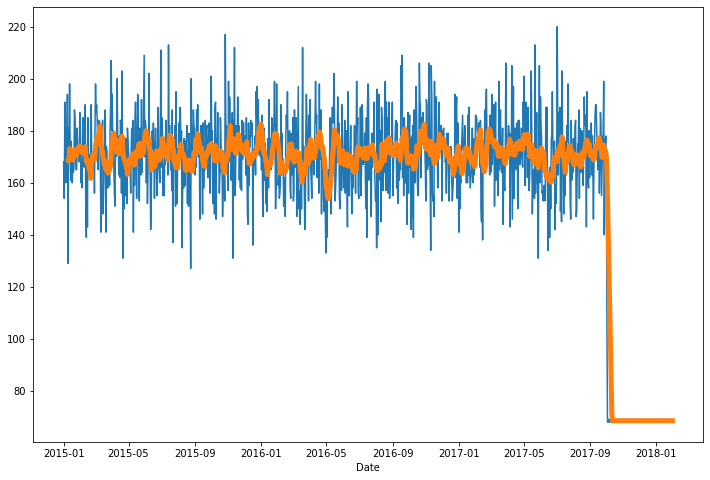

In [39]:
plt.figure(figsize=(12,8))
profits_by_date["Counter"].plot()
profits_by_date["Counter"].rolling(10).mean().plot(lw=5);

In [40]:
profits_by_date.tail(125)

,Order Id,Order Item Cardprod Id,Order Customer Id,Order Department Id,Order Zipcode,Order Item Discount,Order Item Discount Rate,Order Item Id,Order Item Quantity,Sales,Order Item Total,Order Profit,Days for shipping (real),Days for shipment (scheduled),Late Delivery Risk,Product Category Id,Product Description,Product Price,Product Status,Delay,Counter
Date,,,,,,,,,,,,,,,,,,,,,
2017-09-29,12086984,120296,1066089,959,0.0,5028.129999,19.63,30218584,321,42376.980556,37348.870227,4848.889939,659,591,89,5472,0.0,34138.050514,0,68,176
2017-09-30,12237126,108984,911563,908,0.0,5510.000010,17.24,30593483,379,48715.910468,43205.940127,3150.070046,581,474,103,4968,0.0,37347.970382,0,107,178
2017-10-01,11354415,103063,1103786,849,0.0,4686.739994,15.81,28387425,333,49146.500480,44459.810138,7417.730040,605,560,75,4692,0.0,38668.100330,0,45,165
2017-10-02,7163223,83803,810772,605,0.0,1702.369998,8.59,17906668,171,26234.210106,24531.850066,-105.269992,401,314,59,3748,0.0,22194.880086,0,87,104
2017-10-03,4688634,91528,850238,544,0.0,223.739999,7.22,11714054,68,2113.439995,1889.700007,192.300006,255,214,40,4012,0.0,2113.439995,0,41,68
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-01-27,5228962,92684,1390566,272,0.0,1422.249974,6.61,12254382,68,14675.760496,13253.550033,3446.030000,251,196,42,5168,0.0,14675.760496,0,55,68
2018-01-28,5310585,94047,1415742,276,0.0,1519.359971,7.06,12439320,69,14891.580504,13372.250030,2732.139997,224,179,39,5244,0.0,14891.580504,0,45,69
2018-01-29,5238278,92684,1399882,272,0.0,1545.269970,7.18,12263698,68,14675.760496,13130.530029,1915.689980,252,216,35,5168,0.0,14675.760496,0,36,68


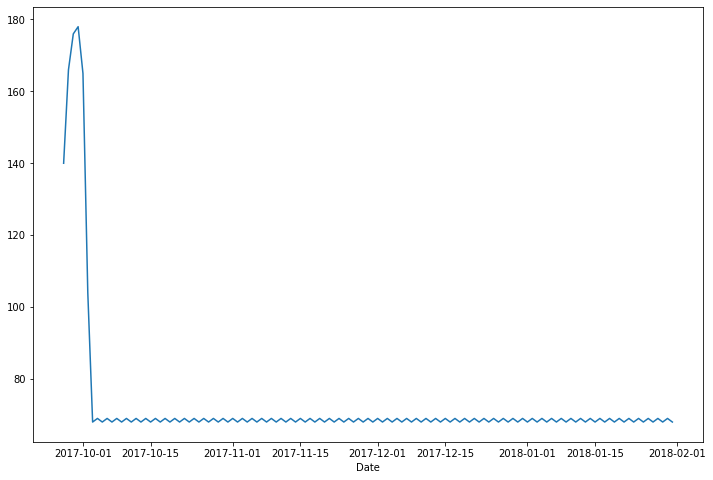

In [41]:
plt.figure(figsize=(12,8))
profits_by_date["Counter"][1000:].plot()

Sudden drop in number of orders per day from 3th Oct 2017.

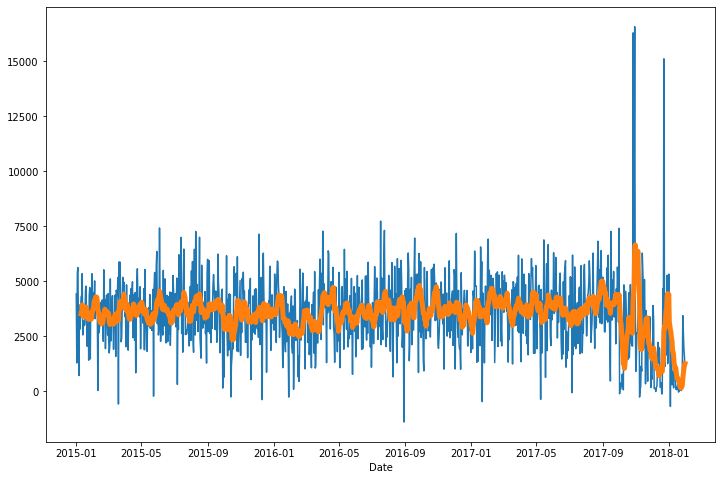

In [42]:
plt.figure(figsize=(12,8))
profits_by_date["Order Profit"].plot()
profits_by_date["Order Profit"].rolling(10).mean().plot(lw=5);

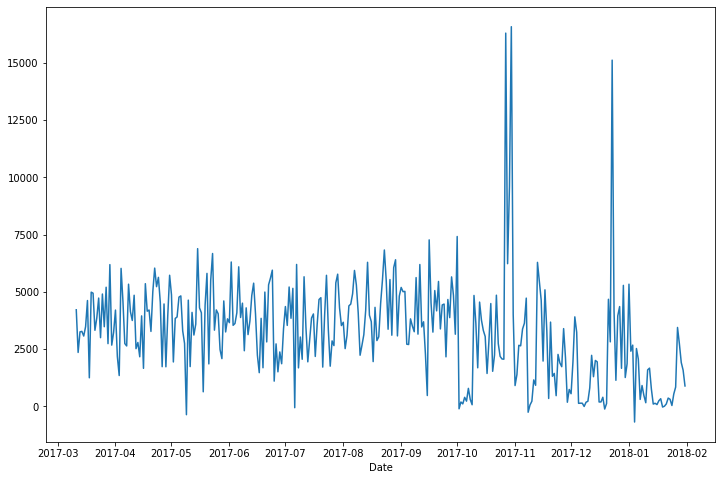

In [43]:
plt.figure(figsize=(12,8))
profits_by_date["Order Profit"][800:].plot()

In [44]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [45]:
profits_by_date.set_index(pd.DatetimeIndex(profits_by_date.index),inplace=True)

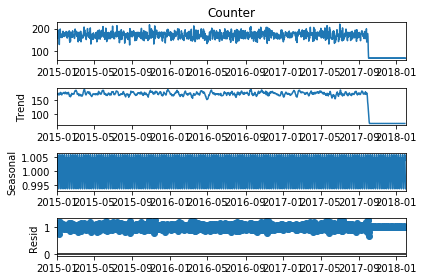

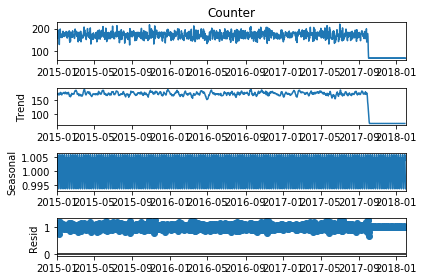

In [46]:
ets_counter = seasonal_decompose(profits_by_date["Counter"], model='multiplicative')
ets_counter.plot()

In [47]:
orders["Month"] = orders["order date (DateOrders)"].dt.to_period('M')
profits_by_month = orders.groupby(by="Month").sum()
profits_by_month.sort_values(by="Month",inplace=True)
profits_by_month.head(10)

,Order Id,Order Item Cardprod Id,Order Customer Id,Order Department Id,Order Zipcode,Order Item Discount,Order Item Discount Rate,Order Item Id,Order Item Quantity,Sales,Order Item Total,Order Profit,Days for shipping (real),Days for shipment (scheduled),Late Delivery Risk,Product Category Id,Product Description,Product Price,Product Status,Delay,Counter
Month,,,,,,,,,,,,,,,,,,,,,
2015-01,5691935,3516834,32769573,28410,0.0,106209.280108,538.310003,14164503,11854,1.051590e+06,945382.160534,111660.740132,18888,16013,2880,160020,0.0,695936.287461,0,2875,5322
2015-02,14580697,3128128,28761775,25275,0.0,93998.570108,480.570002,36351823,10438,9.270099e+05,833012.429253,99140.660196,16545,13715,2594,142314,0.0,617254.795943,0,2830,4729
2015-03,27333316,3564685,33704833,28728,0.0,107204.880113,546.110003,68271665,12062,1.051254e+06,944050.110472,113778.210191,18720,15653,2936,162225,0.0,688674.987211,0,3067,5362
2015-04,36830434,3410983,32482063,27506,0.0,102460.160095,522.120003,92147539,11287,1.014463e+06,912004.400261,108083.679957,18129,15323,2760,155183,0.0,681825.817484,0,2806,5126
2015-05,49808138,3506668,33489271,28418,0.0,106539.920065,542.170003,124378826,11902,1.050478e+06,943939.769956,112147.900143,18616,15634,2951,159603,0.0,689257.647031,0,2982,5357
2015-06,58420284,3378989,31874793,27335,0.0,103765.360104,520.900003,146131609,11203,1.024006e+06,920242.060276,110147.160313,18087,15327,2778,153678,0.0,687196.357350,0,2760,5134
2015-07,71306762,3502817,32990966,28323,0.0,105145.670097,538.010003,178470320,11800,1.038081e+06,932936.790227,115624.059879,18378,15340,2939,159437,0.0,686040.357342,0,3038,5299
2015-08,82190310,3444175,32465973,27962,0.0,104303.010097,538.610003,205467718,11612,1.029495e+06,925192.870536,117979.770302,18295,15151,2936,156734,0.0,685058.247546,0,3144,5273
2015-09,90839683,3388695,31297885,27423,0.0,103817.560115,526.420003,227046650,11366,1.018339e+06,914522.370143,113467.940118,18138,15144,2914,154183,0.0,677782.337374,0,2994,5140


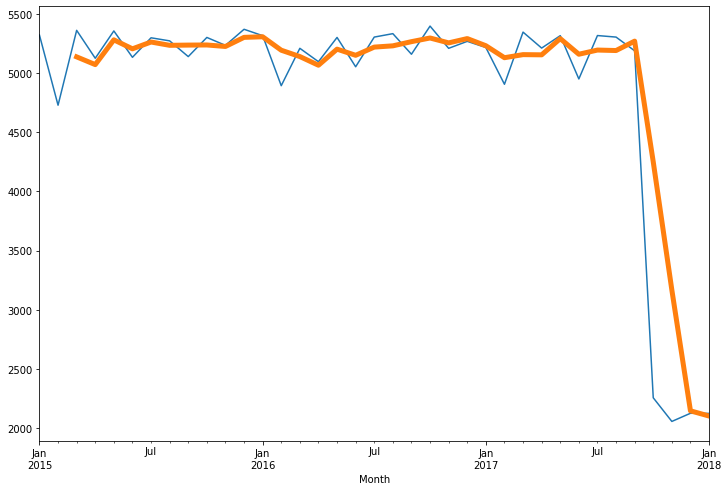

In [48]:
plt.figure(figsize=(12,8))
profits_by_month["Counter"].plot()
profits_by_month["Counter"].rolling(3).mean().plot(lw=5);

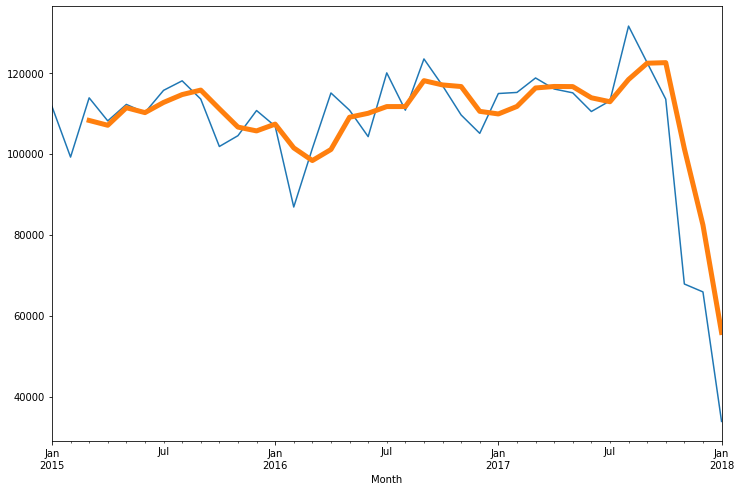

In [49]:
plt.figure(figsize=(12,8))
profits_by_month["Order Profit"].plot()
profits_by_month["Order Profit"].rolling(3).mean().plot(lw=5);

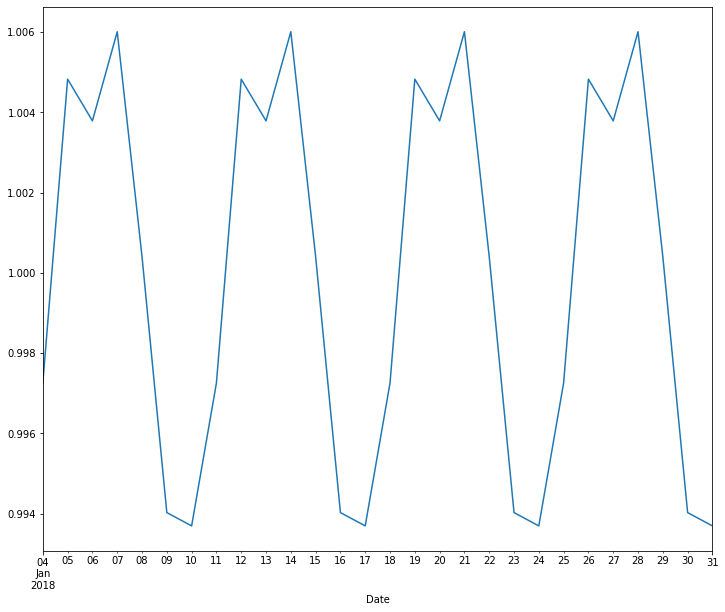

In [50]:
plt.figure(figsize=(12,10))
ets_counter.seasonal[-28:].plot()

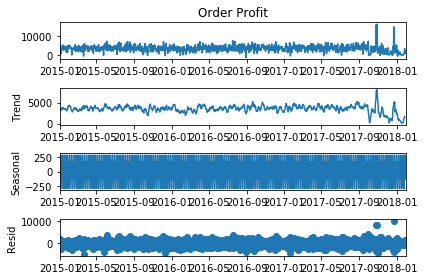

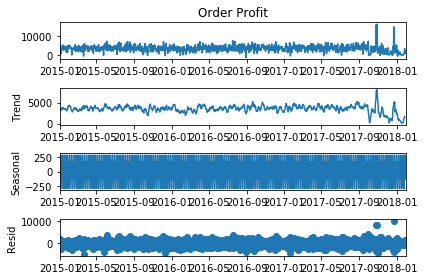

In [51]:
ets_profit = seasonal_decompose(profits_by_date["Order Profit"], model='additive')
ets_profit.plot()

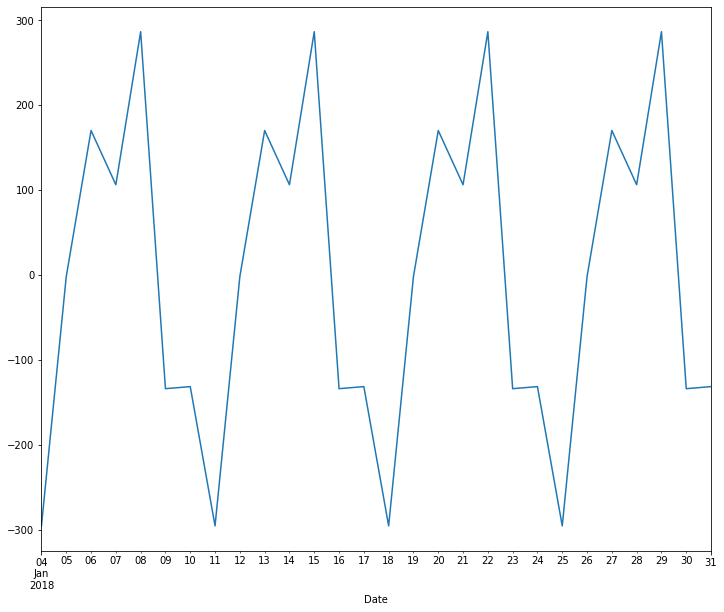

In [52]:
plt.figure(figsize=(12,10))
ets_profit.seasonal[-28:].plot()

In [53]:
df["Counter"] = 1

In [58]:
df = df[(df["lat"] != -1) & (df["long"] != -1)]

In [114]:
#cities with more than 40 orders
by_city_count = df.groupby(by="Order City").sum()
cities = by_city_count[by_city_count["Counter"]>40].index

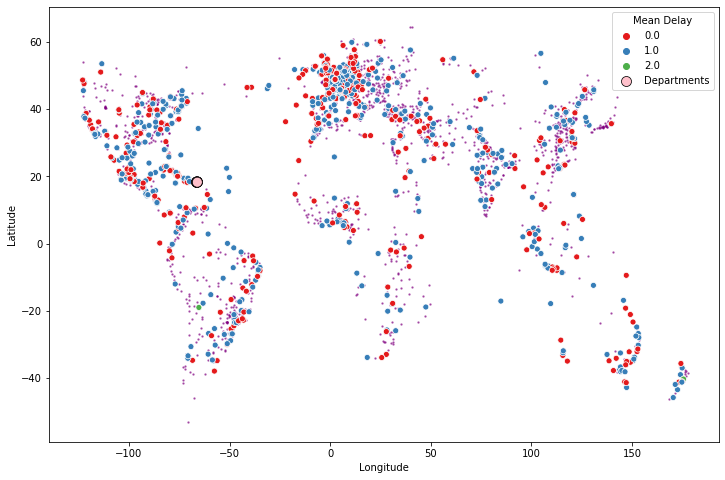

In [246]:
#average delay per city

plt.figure(figsize=(12,8))

plt.scatter(x="long",y="lat",data=df.groupby(by="Order City").mean(),s=2,alpha=0.5,label="",c="purple")
bc = df[df["Order City"].isin(cities)]
by_city = bc.groupby(by="Order City").mean()
by_city["Delay"] = by_city["Delay"].apply(np.round)

city_delays_plot = sns.scatterplot("long","lat",data=by_city,hue="Delay",palette="Set1")
dept_dot = sns.scatterplot("Longitude","Latitude",data=departments,size=1,sizes=[100],
                           label="Departments",edgecolor="black",color="pink")
h,l=city_delays_plot.get_legend_handles_labels()
h2,l2 = dept_dot.get_legend_handles_labels()
h2.append(h)
l2.append(l)
plt.legend(h2[1:5],l2[1:5],title="Mean Delay");


In [175]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.model_selection import train_test_split

In [244]:
x_data = by_city[["long","lat"]]
y_data = by_city["Delay"]
x_train,x_test,y_train,y_test = train_test_split(x_data,y_data,test_size=0.2)

In [245]:
C_values = np.linspace(0.01,10,20)
gamma_values = np.linspace(0.001,10,20)
acc_test = [[]]*len(gamma_values)
acc_train = [[]]*len(gamma_values)

for i in range(len(gamma_values)):
    for j in range(len(C_values)):
        svc = SVC(C=C_values[j],gamma=gamma_values[i])
        svc.fit(x_train,y_train)
        y_pred = svc.predict(x_test)
        acc_test[i].append(accuracy_score(y_test,y_pred))
        acc_train[i].append(accuracy_score(y_train,svc.predict(x_train)))
    

In [240]:
#find the optimal gamma and C parameters (maximum accuracy)

In [247]:
svc = SVC(gamma=2)
svc.fit(x_train,y_train)
y_pred = svc.predict(x_test)

In [248]:
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[14 70  0]
 [19 94  0]
 [ 0  1  0]]
              precision    recall  f1-score   support

         0.0       0.42      0.17      0.24        84
         1.0       0.57      0.83      0.68       113
         2.0       0.00      0.00      0.00         1

    accuracy                           0.55       198
   macro avg       0.33      0.33      0.31       198
weighted avg       0.51      0.55      0.49       198



/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
